In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

from HigherTier import HigherTierModel
from HigherTier import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_shower.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_shower.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 6))
variables_test = np.empty((0, 6))

# Truth
y_train = np.empty((0))
y_test = np.empty((0))
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)                                             

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_shower.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (178437, 6)
variables_test.shape: (19827, 6)
y_train.shape: (178437,)
y_test.shape: (19827,)
isTruePrimaryLink_train.shape: (178437,)
isTruePrimaryLink_test.shape: (19827,)


In [6]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.PrimaryShowerFinalOutputModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['binary_crossentropy'])

In [7]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(isTruePrimaryLink_train == 1)
nBackground_final = np.count_nonzero(isTruePrimaryLink_train == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('nTrue_final:', nTrue_final)
print('nBackground_final:', nBackground_final)
print('classWeights_final:', classWeights_final)

nTrue_final: 125284
nBackground_final: 53153
classWeights_final: {0: 2.3570447575865896, 1: 1.0}


In [8]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model.fit(variables_train, isTruePrimaryLink_train, validation_data=(variables_test, isTruePrimaryLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
2680/2789 [===========================>..] - ETA: 0s - loss: 0.8476 - accuracy: 0.6199
Epoch 1: val_accuracy improved from -inf to 0.64155, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 457us/step - loss: 0.8456 - accuracy: 0.6208 - val_loss: 0.5757 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 2/10
2702/2789 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.6910
Epoch 2: val_accuracy improved from 0.64155 to 0.73778, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 417us/step - loss: 0.7773 - accuracy: 0.6926 - val_loss: 0.5470 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 3/10
2632/2789 [===========================>..] - ETA: 0s - loss: 0.7551 - accuracy: 0.7562
Epoch 3: val_accuracy improved from 0.73778 to 0.76436, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 400us/step - loss: 0.7549 - accuracy: 0.7571 - val_loss: 0.5407 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 4/10
2721/2789 [============================>.] - ETA: 0s - loss: 0.7461 - accuracy: 0.7736
Epoch 4: val_accuracy improved from 0.76436 to 0.77596, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 392us/step - loss: 0.7459 - accuracy: 0.7738 - val_loss: 0.5328 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 5/10
2682/2789 [===========================>..] - ETA: 0s - loss: 0.7425 - accuracy: 0.7794
Epoch 5: val_accuracy improved from 0.77596 to 0.78065, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 399us/step - loss: 0.7422 - accuracy: 0.7795 - val_loss: 0.5299 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 6/10
2700/2789 [============================>.] - ETA: 0s - loss: 0.7403 - accuracy: 0.7821
Epoch 6: val_accuracy improved from 0.78065 to 0.78267, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 415us/step - loss: 0.7406 - accuracy: 0.7822 - val_loss: 0.5293 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 7/10
2667/2789 [===========================>..] - ETA: 0s - loss: 0.7395 - accuracy: 0.7836
Epoch 7: val_accuracy improved from 0.78267 to 0.78449, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 419us/step - loss: 0.7397 - accuracy: 0.7836 - val_loss: 0.5263 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 8/10
2742/2789 [============================>.] - ETA: 0s - loss: 0.7392 - accuracy: 0.7848
Epoch 8: val_accuracy did not improve from 0.78449
2789/2789 [==============================] - 1s 380us/step - loss: 0.7391 - accuracy: 0.7848 - val_loss: 0.5301 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 9/10
2779/2789 [============================>.] - ETA: 0s - loss: 0.7388 - accuracy: 0.7853
Epoch 9: val_accuracy improved from 0.78449 to 0.78509, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2789/2789 [==============================] - 1s 406us/step - loss: 0.7387 - accuracy: 0.7853 - val_loss: 0.5288 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 10/10
2722/2789 [============================>.] - ETA: 0s - loss: 0.7386 - accuracy: 0.7858
Epoch 10: val_accuracy improved from 0.78509 to 0.78524, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2789/2789 [==============================] - 1s 413us/step - loss: 0.7385 - accuracy: 0.7858 - val_loss: 0.5289 - val_accuracy: 0.7852 - lr: 1.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


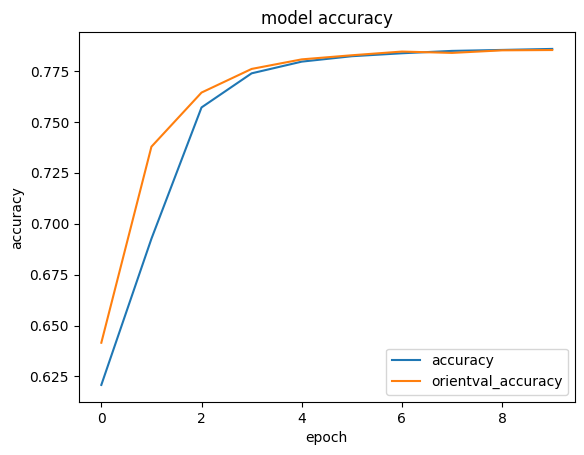

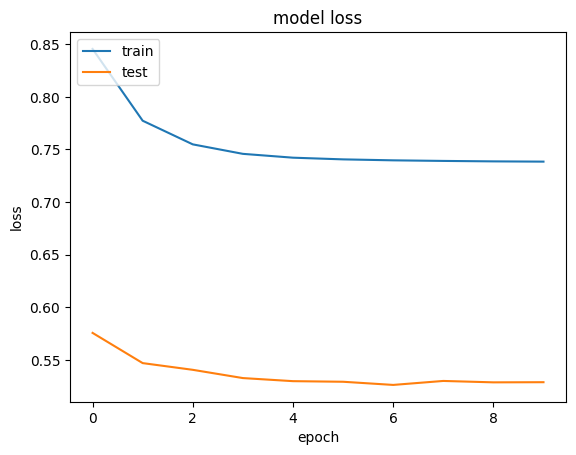

In [9]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model.predict(variables_train)
y_pred_final_test = model.predict(variables_test)

620/620 [==============================] - 0s 242us/step


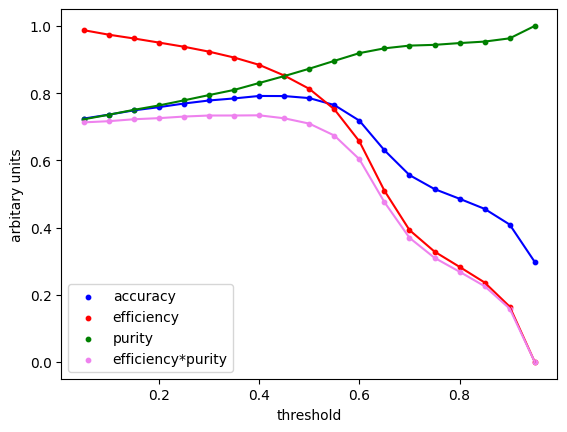

optimal_threshold_metric: 0.4


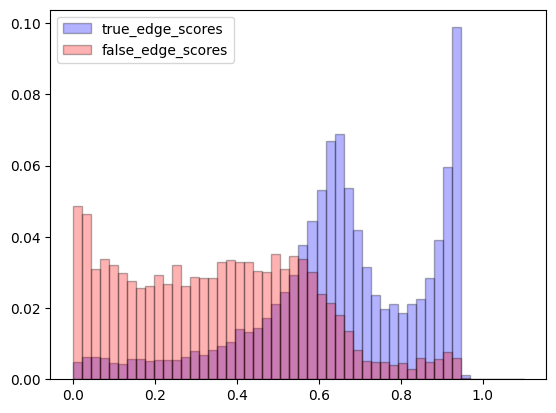

[[ 4250  1651]
 [ 2607 11319]]
[[ 3382  2519]
 [ 1613 12313]]


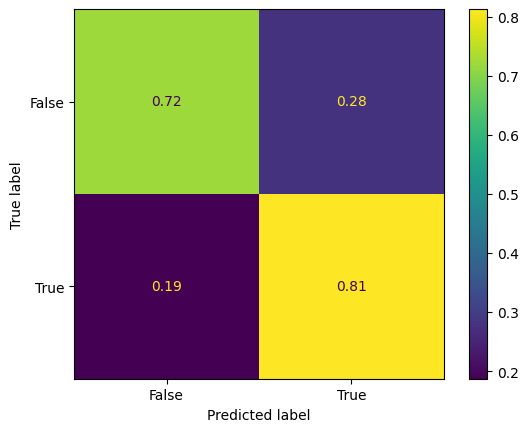

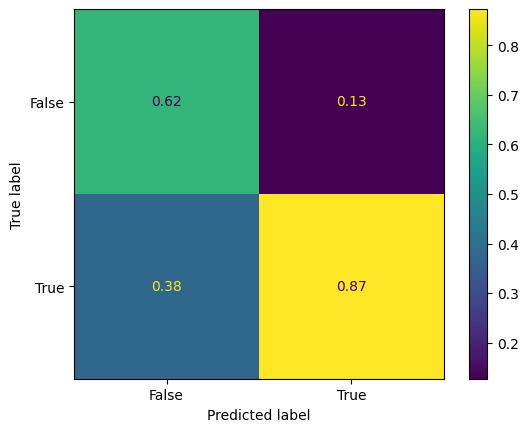

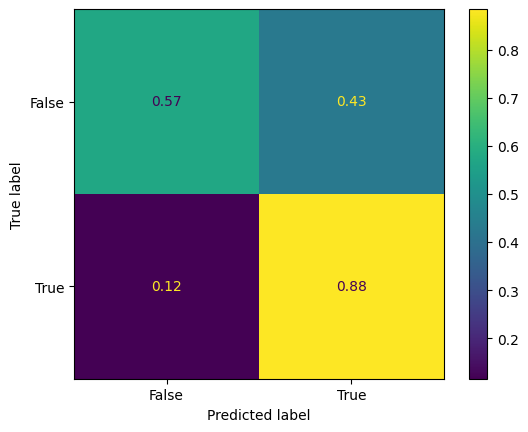

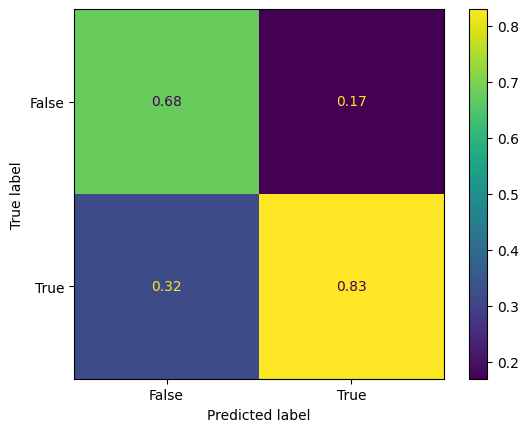

In [11]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, isTruePrimaryLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, isTruePrimaryLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, optimal_threshold_metric)
